---
layout: post
title:  "Painting the Girl with a Pearl Earring with Genetic Algorithms: Part Two"
short_title: "Genetic Algorithms 2: Painting Vermeer"
desc: "A gentle introduction to genetic algorithms by recreating painting classics"
long_desc: "In this tutorial, we'll introduce a population based genetic algorithm to recreate classic art using simply geometry"
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/genetic2"

math: true
---


This is what we're going to make in this tutorial. Building on from the previous discussion in [part one](/genetic1), we now add population and genetic mixing into the algorithm.

In [3]:
from IPython.display import Video
from IPython.display import Image
Video("genetic2/output.mp4")

!!! img-smaller

In the [prior article](/genetic1) we evolved a painting by the process of having a single organism that we mutated over time. We aim to improve this algorithm in this step by adding multiple different organisms into the population, and allowing those organisms to mate and produce offspring.

Let's write out our imports now to get them out of the way.

In [2]:
import os
import numpy as np
from numpy.random import choice, random, normal
from colour import Color
import json
import pygame  # Pygame for nice fast drawing
import subprocess ###REMOVE

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


As before, we define an organism. You'll note it looks very much like the one from the previous article, except that now I have increased the chance the when a gene mutates, its the hue of the cirlce that changes (hue being located in index 3).

In [182]:
class Organism:
    def __init__(self, genes):
        self.chromosome = np.clip(genes, 0, 1)
        self.visual = None
        self.fitness = None
        
    def mutate(self, rate=0.01, scale=0.3, add=0.3):
        """ Get a mutated organism given the mutation rates and scale input """
        chromosome = np.copy(self.chromosome)
        n_gene, n_feat = chromosome.shape

        # Here we can add/remove a gene, or mutate an existing one
        if random() > add:
            # Mutate features in our genes
            num_mutations = 1 + int(rate * n_gene)
            # As we mutate more, the size of mutations decreases
            scale2 = scale / num_mutations
            for i in range(num_mutations):
                if random() > 0.5:
                    i = 3
                else:
                    i = choice(n_feat)
                chromosome[choice(n_gene), i] += normal() * scale2
                if i == 3:
                    chromosome[:, i] = np.mod(chromosome[:, i], 1)
        else:
            # Either add or remove a gene
            if random() < 0.3:
                chromosome = np.delete(chromosome, choice(n_gene), axis=0)
            else:
                # When we add, we'll do so by blending two existing genes 
                # and perturbing it. More likely to find a good gene this way.
                a, b = choice(n_gene, 2, replace=False)
                gene = np.atleast_2d(0.5 * (chromosome[a, :] + chromosome[b, :]))
                gene += scale * normal(size=(1, gene.size))
                gene[:, 2] *= 0.2
                chromosome = np.append(chromosome, gene, axis=0)
                
        return Organism(chromosome)
    

Here lie the main changes from the previous section - our population now acutally has a population. Dramatic stuff. Specifically for changes, we now have:

* `spawn` spawns a population now, not just one individual
* `save` and `load` allow us to save out and load in a population so I can give my poor laptop a break when it starts to melt.
* `get_child` takes two parents and picks genes from both 
* `mutate_and_pick` which tries several times to mutate the organism to a better version
* `step` which now generates childre, mutates them, and then picks the cream of the crop to survive.


In [183]:
class Population:
    def __init__(self, path):
        """ Load in the reference image and create a surface we can draw on. """
        pygame.init()
        self.ref = pygame.surfarray.pixels3d(pygame.image.load(path))
        w, h, d = self.ref.shape
        self.screen = pygame.Surface((w, h))
        self.screen.fill((255, 255, 255))
        
        self.population = []

    def draw(self, organism):
        """ Draw an organism by expressing each gene in term """
        w, h, d = self.ref.shape
        screen = self.screen.copy()
        for gene in organism.chromosome:
            x, y, size, *hsl = gene
            position = (int(x * w), int(y * h))
            c = tuple(map(lambda x: int(255 * x),  Color(hsl=hsl).rgb))
            pygame.draw.circle(screen, c, position, int((size * 0.3 + 0.01) * w))
        return screen
    
    def spawn(self, pop_size=30, complexity=10):
        """ Spawn a new population with `complexity` genes in each member with """
        for i in range(pop_size):
            organism = Organism(random((complexity, 6)))
            self.population.append(organism) 
            self.calc_fitness(organism)
        self.population = sorted(self.population, key=lambda x: -x.fitness)
        
    def calc_fitness(self, organism):
        """ Calculate the fitness of a gene by drawing it and comparing
        it to the reference """
        screen = self.draw(organism)
        diff = pygame.surfarray.pixels3d(screen) - self.ref
        organism.fitness = -np.mean(np.abs(diff)) - 1e-5 * organism.chromosome.size
        organism.visual = screen

    def get_child(self, a, b):
        """ Breed a and b by mixing the common length genes, keeping most from 
        the first parent. """
        new_genes = []
        n_a, n_b = a.chromosome.shape[0], b.chromosome.shape[0]
        for i in range(max(n_a, n_b)):
            if i < n_a and i < n_b:
                if random() < 0.7:
                    new_genes.append(a.chromosome[i, :])
                else:
                    new_genes.append(b.chromosome[i, :])
            elif i < n_a:
                new_genes.append(a.chromosome[i, :])
            else:
                if random() < 0.3:
                    new_genes.append(b.chromosome[i, :])
            chromosome = np.array(new_genes)
        o = Organism(chromosome)
        self.calc_fitness(o)
        return o
    
    def save(self, path):
        """ Save population to json file """
        out = [o.chromosome.tolist() for o in self.population]
        with open(path, "w") as f:
            json.dump(out, f)
            
    def load(self, path):
        """ Load population from json file """
        with open(path) as f:
            inp = json.load(f)
        self.population = [Organism(np.array(x)) for x in inp]
        for o in self.population:
            self.calc_fitness(o)
            
    def mutate_and_pick(self, organism, rate, scale, add, attempts=10):
        """ Mutate organism attempts times to try and get something better """
        for i in range(attempts):
            o = organism.mutate(rate=rate, scale=scale, add=add)
            self.calc_fitness(o)
            if o.fitness > organism.fitness:
                return o
        return organism
            
    def step(self, time, outdir, rate=0.01, scale=0.1, add=0.3):
        """ Take a step in time by making some kids, mutating them,
        and then letting the fittest survive. Nature is a harsh mistress."""
        
        # Get some children by picking the fitter parents
        new_orgs = []
        weights = 1 - np.linspace(0, 0.2, len(self.population))
        for i in range(len(self.population)):
            a, b = choice(self.population, 2, replace=True, p=weights / weights.sum())
            child = self.get_child(a, b)
            new_orgs.append(self.mutate_and_pick(child, rate, scale, add))
            
        # Calculate fitness,sort fitness, update population
        for o in new_orgs:
            self.calc_fitness(o)
        sorted_orgs = sorted(new_orgs, key=lambda x: -x.fitness)
        self.population = sorted_orgs[:len(self.population)]

        # Save out the image if we want it
        path = outdir + f"{time:04d}.png"
        pygame.image.save(self.population[0].visual, path)
        self.save(outdir + "save.json")


With this population, we can create a handy helper function (again) which points to a reference image, sets an output directup up, and then either loads the checkpoint, or starts anew if its not found!

When I feel like I have enough samples I'll terminate the function myself - those are more steps than my laptop could ever generate.

In [184]:
def evolve(rate, scale, add_chance, steps=700000):
    pop = Population("genetic2/earring.png")
    outdir = f"genetic2/output/"
    os.makedirs(outdir, exist_ok=True)
    save = outdir + "save.json"
    if os.path.exists(save):
        pop.load(save)
        start = int(sorted(os.listdir(outdir))[-2][:-4]) * 2
    else:
        pop.spawn(complexity=20)
        start = 0    
    for i in range(start, steps):
        pop.step(i, outdir, rate=rate, scale=scale, add=add_chance)

With this all set up, we can now call `evolve` and see what we get. Here's our starting point again:

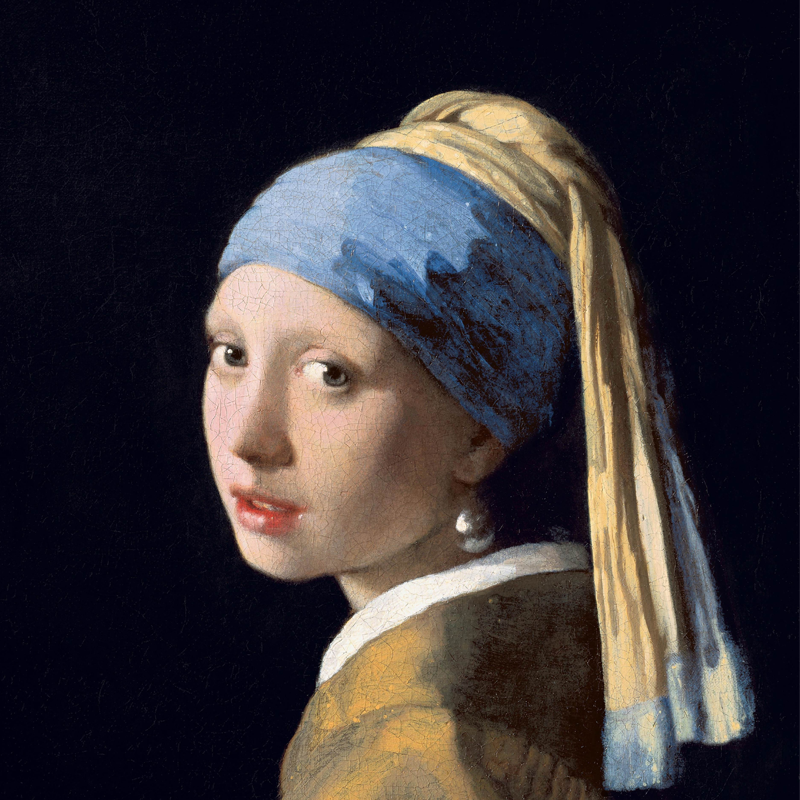

In [194]:
Image("genetic2/earring.png")

!!!main small

And now lets kick it off:

In [ ]:
# 1% chance of mutation, scale is a normal of std 0.1, and 1% chance to add or remove
evolve(0.01, 0.1, 0.01)

I also grabbed some snapshots of the population at the start and then as we progress further. The three images are the population at the start, after 40 iterations, and much later one. Notice that even though the populations grow more similar, each organism is still unique.

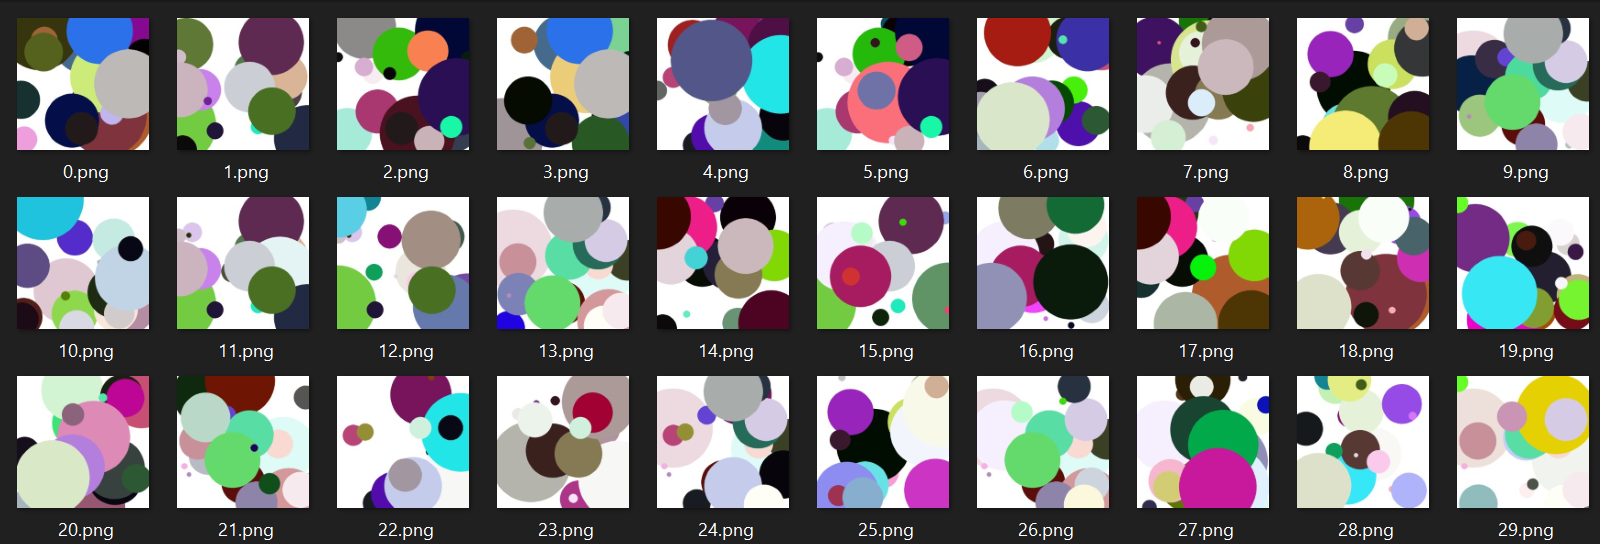

In [7]:
Image("genetic2/pop_start.png")

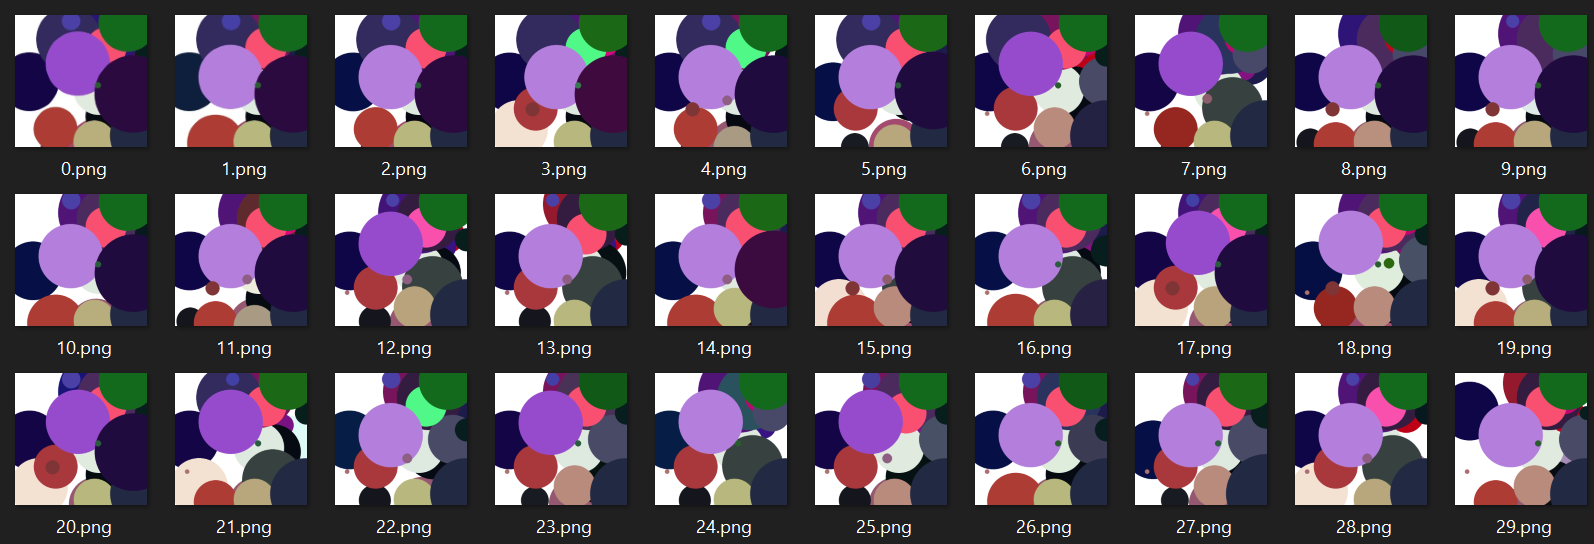

In [6]:
Image("genetic2/pop_40.png")

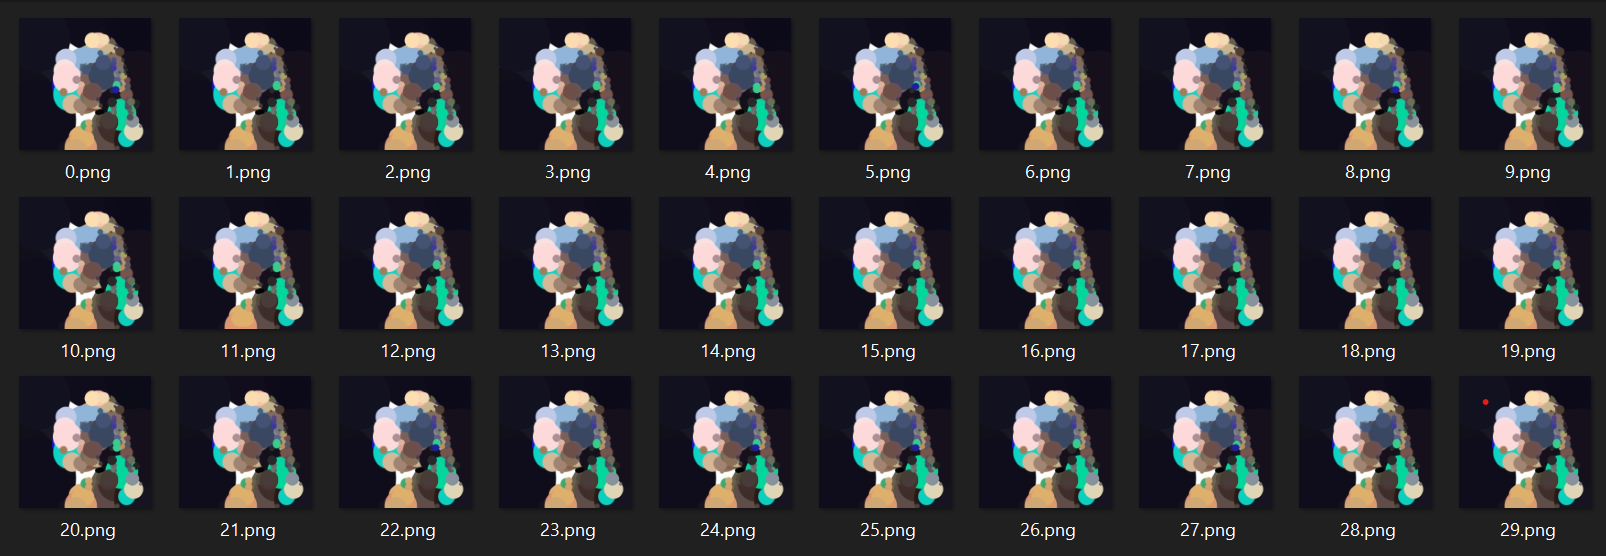

In [8]:
Image("genetic2/pop_late.png")

Using our good friend `ffmpeg` to turn some of these PNGs into an animation, we get this:

In [195]:
import shutil
outdir = "genetic2/output/"
outdir2 = outdir.replace("output", "processed")
os.makedirs(outdir2, exist_ok=True)
nums = [int(x[:-4]) for x in sorted(os.listdir(outdir)) if "png" in x]
max_step = np.max(nums)
frames = np.unique(np.geomspace(1, max_step, 1200).astype(int))
for i, f in enumerate(frames):
    shutil.copyfile(outdir + f"{f:04d}.png", outdir2 + f"{i:04d}.png")
    if f == frames[-1]:
        shutil.copyfile(outdir + f"{f:04d}.png", "genetic2/final.png")

command = f"ffmpeg -r 60 -i {outdir2}%04d.png -vcodec libx264 -y -filter_complex \"tpad=stop_duration=3:stop_mode=clone\" -crf 23 -movflags faststart -pix_fmt yuv420p {outdir[:-1]}.mp4" ###REMOVE
subprocess.run(command)  ### REMOVE
Video(outdir[:-1] + ".mp4") ###REMOVE

And heres a side by side:

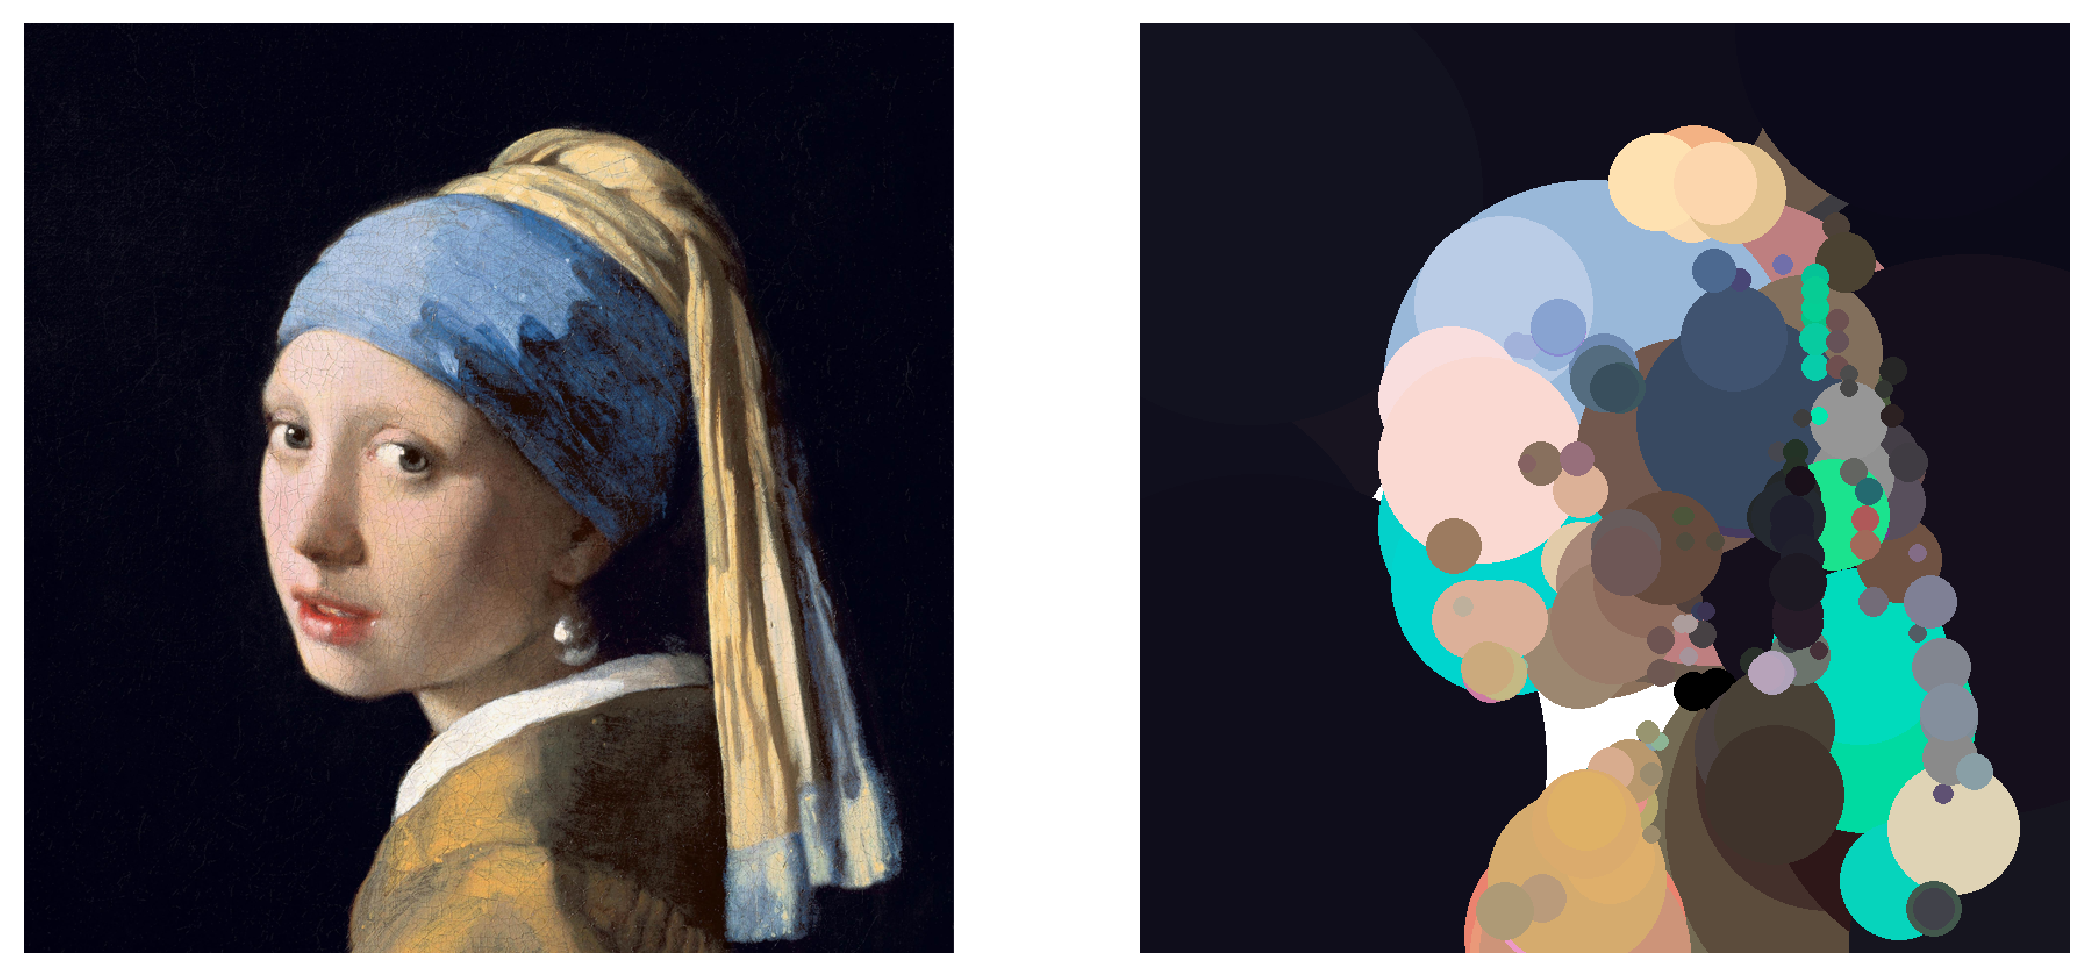

In [196]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# read images
img_A = mpimg.imread('genetic2/earring.png')
img_B = mpimg.imread('genetic2/final.png')

# display images
fig, axes = plt.subplots(ncols=2, figsize=(11 ,8))
axes[0].imshow(img_A);
axes[1].imshow(img_B);
axes[0].axis('off');
axes[1].axis('off');

This still took quite a whil to run on my laptop, and there are existing solutions out there. If you have a serious problem and require an efficient and sophisticated genetic algorithm to help you out, check out the [DEAP](https://deap.readthedocs.io/en/master/) python package.